#

# Tarea Gradient Boosting
## Arantza Gomez Haro Gamboa

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from xgboost import plot_importance
import lightgbm as lgb


In [58]:
def calibracion_multiple(modelos, y, bins):
    for nombre, predicciones in modelos.items():
        df_calibracion = pd.DataFrame({
            'predicciones': predicciones,
            'y': y
        })
        
        df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
        grouped = df_calibracion.groupby('bins').mean()
        
        plt.figure()
        plt.plot(grouped.predicciones, grouped.y, label=f"{nombre} (Modelo)", marker="o", color="darkmagenta")
        plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o", color="lightseagreen")
        
        plt.grid()
        plt.legend()
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Calibración para {nombre}")

## **Datos**

In [59]:
df = pd.read_csv('Boston.csv')
df = df.drop(columns = ['Unnamed: 0'])
df = pd.get_dummies(df, columns = ['rad'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


In [60]:
target = 'medv'
y = df[target]
X = df.copy().drop(target, axis=1)
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,lstat,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,4.98,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,9.14,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,4.03,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,2.94,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,5.33,False,False,True,False,False,False,False,False,False


## **Modelos**

### LightGBM:

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [62]:
model = LGBMRegressor(
    n_estimators=10_000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=6,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse',
          callbacks=[early_stopping(40),
                     log_evaluation(100)])

Training until validation scores don't improve for 40 rounds
[100]	training's rmse: 1.78161	training's l2: 3.17414	valid_1's rmse: 3.32032	valid_1's l2: 11.0245
[200]	training's rmse: 1.22229	training's l2: 1.49399	valid_1's rmse: 3.24876	valid_1's l2: 10.5544
[300]	training's rmse: 0.913703	training's l2: 0.834852	valid_1's rmse: 3.22429	valid_1's l2: 10.396
Early stopping, best iteration is:
[277]	training's rmse: 0.971781	training's l2: 0.944357	valid_1's rmse: 3.20868	valid_1's l2: 10.2956


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=6,
              n_estimators=10000, num_leaves=10, subsample=0.8, verbosity=-1)

In [63]:
predicciones_light = model.predict(X_test)
r2_light = r2_score(y_pred=predicciones_light, y_true=y_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

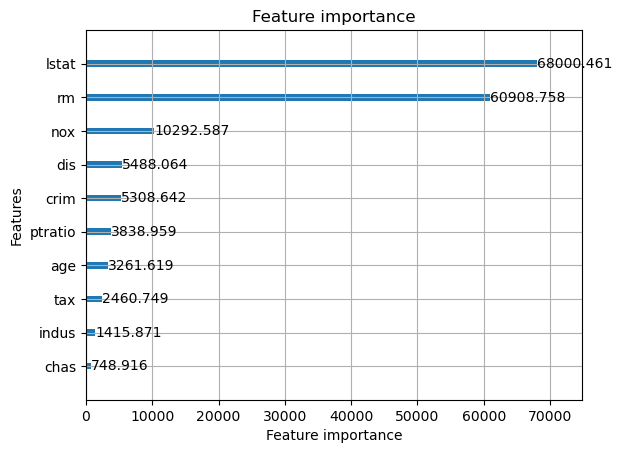

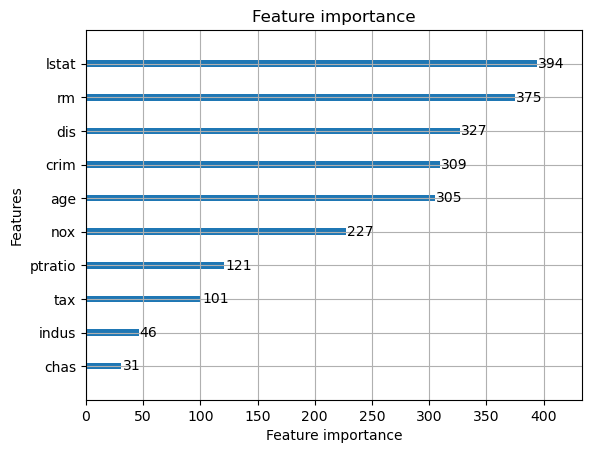

In [64]:
lgb.plot_importance(model, max_num_features = 10, importance_type='gain')
lgb.plot_importance(model, max_num_features = 10, importance_type='split')

### XGBoost:

In [65]:
model = XGBRegressor(
    n_estimators = 10_000,
    max_depth = 5,
    learning_rate = 0.1,
    reg_lambda = 0.1,
    subsample = 0.5,
    col_sample_by_tree = 0.8,
    tree_method = 'hist',
    early_stopping_rounds = 40
)

model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:8.56427	validation_1-rmse:8.01965
[100]	validation_0-rmse:0.71727	validation_1-rmse:2.89519


c:\Users\arant\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:22:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "col_sample_by_tree" } are not used.

  self.starting_round = model.num_boosted_rounds()


[200]	validation_0-rmse:0.26647	validation_1-rmse:2.88992
[208]	validation_0-rmse:0.25045	validation_1-rmse:2.88826


XGBRegressor(base_score=None, booster=None, callbacks=None,
             col_sample_by_tree=0.8, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, device=None,
             early_stopping_rounds=40, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None, ...)

In [66]:
predicciones_xg = model.predict(X_test)
r2_xg = r2_score(y_pred=predicciones_xg, y_true=y_test)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

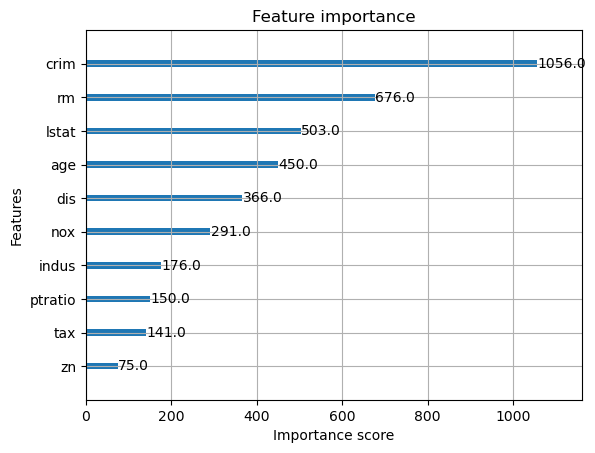

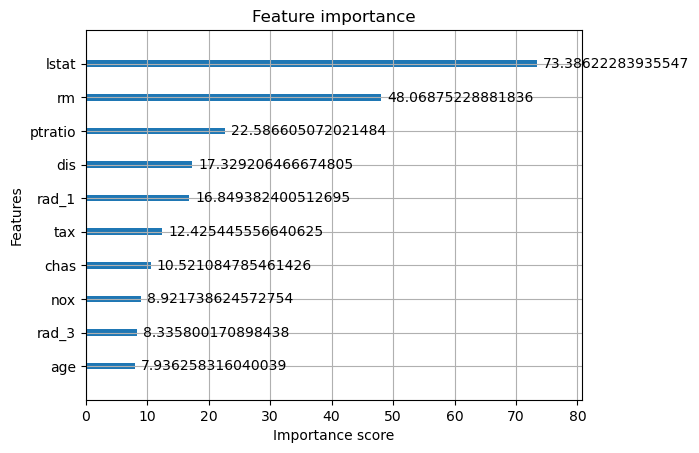

In [67]:
plot_importance(model, max_num_features=10, importance_type="weight")
plot_importance(model, max_num_features=10, importance_type="gain")

### CatBoost:

In [68]:
cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]

for col in cat_cols:
    X_train[col] = X_train[col].astype(str).fillna('missing')
    X_test[col] = X_test[col].astype(str).fillna('missing')

In [69]:
model = CatBoostRegressor(
    iterations=10_000,         
    depth=5,                   
    learning_rate=0.1,
    subsample=0.5,             
    rsm=0.8,                  
    eval_metric='R2',
    early_stopping_rounds=40,
    verbose = 100)           

model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=[(X_test, y_test)],
)

predicciones_catboost = model.predict(X_test)
r2_catboost = r2_score(y_pred=predicciones_catboost, y_true=y_test)


0:	learn: 0.1153772	test: 0.0818185	best: 0.0818185 (0)	total: 41.4ms	remaining: 6m 54s
100:	learn: 0.9527773	test: 0.8779621	best: 0.8781744 (97)	total: 6.76s	remaining: 11m 2s
200:	learn: 0.9778520	test: 0.8856876	best: 0.8856876 (200)	total: 11.4s	remaining: 9m 13s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8858755249
bestIteration = 214

Shrink model to first 215 iterations.


In [70]:
df_importances = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

df_importances

,feature,importance
10,lstat,37.430709
5,rm,28.859286
7,dis,8.398689
0,crim,5.390467
4,nox,5.298924
8,tax,2.904039
6,age,2.895261
2,indus,2.428188
9,ptratio,1.654850
15,rad_5,1.450324


## **Gráficas de calibración**

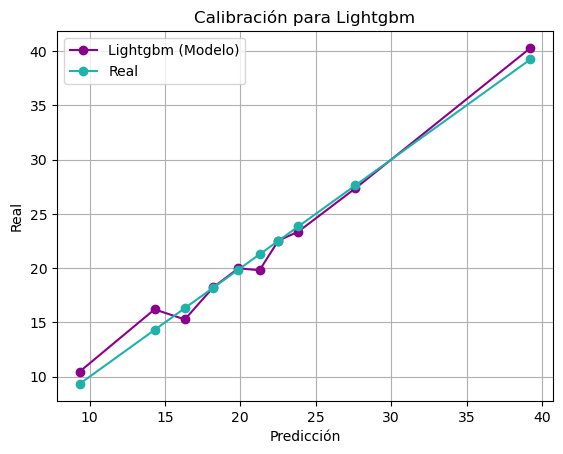

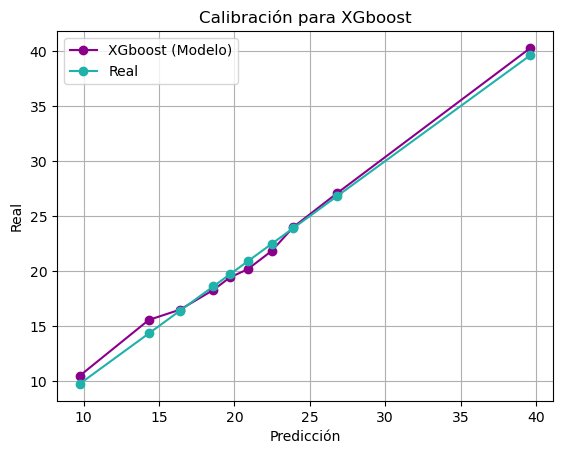

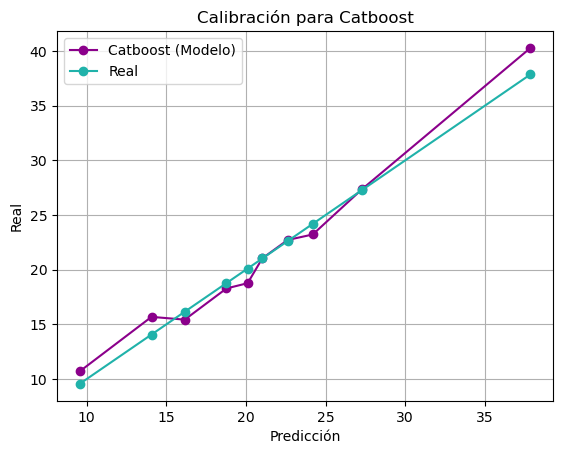

In [71]:
modelos = {
    'Lightgbm': predicciones_light,
    'XGboost': predicciones_xg,
    'Catboost': predicciones_catboost,
}

calibracion_multiple(modelos, y_test, bins=10)

## **R2 Score**

In [72]:
tabla = pd.DataFrame({
    'LightGBM': r2_light,
    'XGBoost': r2_xg,
    'CatBoost': r2_catboost
}, index=['R2 Score'])
tabla

,LightGBM,XGBoost,CatBoost
R2 Score,0.861828,0.8881,0.885876


## **Análisis**

- Con la tabla anterior, se puede apreciar que el modelo que obtuvo el R2 Score mayor fue el de XGBoost, con un valor de 0.8881. Este fue seguido por el modelo CatBoost con un R2 de 0.8859, y luego LightGBM con un R2 de 0.8618. Dicho esto, es importante mencionar que el modelo realizado con feature engineering en el examen 1 obtuvo un R2 Score mayor a todos estos modelos, con un valor de 0.9029. 

- En cuestión del modelo LightGBM, al momento de hacer feature importance, se puede ver que las variables que aparecen más arriba usando "gain" son **lstat**, **rm** y **nox**. Esto nos indica que estos features ayudan a aumentar la precisión del modelo. Por otro lado, en cuestión del "split", las variables más importantes fueron **lstat**, **rm** y **dis**: Estas variables son las que se utilizaron más veces en el modelo. 

- Con el modelo XGBoost, las variables que más ayudan a aumentar la precisión son **lstat**, **rm** y **ptratio**, mientras que las variables que más se utilizaron fueron **crim**, **rm** y **lstat**.

- Por último, en el modelo CatBoost, las variables que contribuyen más en el modelo son **lstat**, **rm** y **dis**. Aquí, es importante mencionar que estas 3 características representan casi el 75% de la importancia total del modelo, lo cual nos indica una dependencia de estos features para la precisión del modelo CatBoost. 

- Por último, se puede analizar claramente que todos los modelos tienen con mayor importance a las variables de **lstat** y **rm**, lo cual demuestra que son muy relevantes en este dataset.

-  Gracias a esto funcionó

In [2]:
print('prueba')

prueba


Va